In [71]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Scraping

The `scrape_crewling` function takes two arguments: `fetched_content` and `argument`. It processes the fetched content, which is a list of HTML content obtained from web pages, and the `argument` dictionary. It extracts specific information from the HTML content using BeautifulSoup and constructs a list of dictionaries. Finally, it returns a pandas DataFrame based on the constructed list.

Here's a breakdown of what the function does:

1. Initialize an empty list `data` to store dictionaries containing the extracted information.
2. Iterate over each `content` in the `fetched_content` list.
3. Parse the HTML content using BeautifulSoup with the 'html.parser' parser.
4. Find all the div elements with a class of 'card-block', which typically contain the desired information.
5. Iterate over each `item` in the found `feed_items`.
6. Extract the values for specific fields such as 'KM', 'Year', 'Price', 'Hand', and 'Company' from the respective HTML elements using their class or tag names.
7. Append a dictionary with the extracted values and additional information from the `argument` dictionary to the `data` list.
   - The 'FuelType' and 'EngineType' values are retrieved from the `argument` dictionary using the `get` method.
8. Return a pandas DataFrame constructed from the `data` list.
   - The column names are specified as 'Hand', 'Year', 'Company', 'Price', 'KM', 'FuelType', and 'EngineType'.

Overall, the function performs web scraping operations to extract specific information from the fetched HTML content and constructs a DataFrame containing that information along with additional details from the `argument` dictionary.

In [59]:
def scrape_crewling(fetched_content, argument):
    data = []
    for content in fetched_content:
        soup = BeautifulSoup(content, 'html.parser')
        feed_items = soup.find_all('div', {'class': 'card-block'})

        for item in feed_items:
            km_element = item.find('span', {'class': 'ms-1'})
            km_value = km_element.get_text(strip=True) if km_element else None

            year_element = item.find('p', {'class': 'card-text'})
            year_value = year_element.get_text(strip=True) if year_element else None

            price_element = item.find('div', {'class': 'price ms-1'})
            price_value = price_element.get_text(strip=True) if price_element else None

            hand_element = item.find('div', {'class': 'flex-fill card-icon-wrapper'})
            hand_value = hand_element.get_text(strip=True) if hand_element else None

            name_element = item.find('h2', {'class': 'card-title mb-0 mb-sm-1'})
            name_value = name_element.get_text(strip=True) if name_element else None


            data.append({"Hand": hand_value, "KM": km_value, "Year": year_value, "Company": name_value, "Price": price_value, "FuelType": argument.get('FuelType'), "EngineType": argument.get('EngineType')})

    return pd.DataFrame(columns=['Hand', 'Year', 'Company', 'Price','KM', 'FuelType', 'EngineType'], data=data)



# Crewling

The `fetch_content` function takes two arguments: `url` and `number_of_pages`. It fetches the content from multiple pages of a given URL and returns a list of the fetched content.
The function essentially makes a series of HTTP requests to the provided URL with different page numbers, fetches the content of each page, and stores it in a list. The `number_of_pages` argument determines how many pages will be fetched.


The `create_df_and_fetch_content` function takes two arguments: `url` and `argument`.
The function proceeds to call the `fetch_content` function, passing the `url` and `argument['number_of_pages']` as arguments. The `fetch_content` function is responsible for fetching the content from multiple pages of the given URL, as explained in the previous description.
The fetched content is then passed to the `scrape_crewling` function along with the `argument`. The `scrape_crewling` function is responsible for extracting specific information from the fetched content and constructing a pandas DataFrame, as described earlier.
Finally, the function returns the resulting DataFrame generated by the `scrape_crewling` function.

In [60]:
def fetch_content(url, number_of_pages):
    content = []
    for page in range(1, number_of_pages):
        page_url = url + str(page)
        response = requests.get(page_url)
        if response.status_code == 200:
            content.append(response.content)
    return content

def create_df_and_fetch_content(url, argument):
    fetched_content = fetch_content(url, argument['number_of_pages'])
    return scrape_crewling(fetched_content, argument)

def start_process():
    dfs = []
    url_arguments = {
        "https://www.ad.co.il/car?sp266=15516&sp267=14527&pageindex=": {
            'FuelType': 'Gas',
            'EngineType': 'Automatic',
            "number_of_pages": 756
        },
        "https://www.ad.co.il/car?sp266=15516&sp267=14529&pageindex=": {
            'FuelType': 'Diesel',
            'EngineType': 'Automatic',
            "number_of_pages": 74
        },
        "https://www.ad.co.il/car?sp266=15514&sp267=14527&pageindex=": {
            'FuelType': 'Gas',
            'EngineType': 'Manual',
            "number_of_pages": 37
        },
        "https://www.ad.co.il/car?sp266=15514&sp267=14529&pageindex=": {
            'FuelType': 'Diesel',
            'EngineType': 'Manual',
            "number_of_pages": 9
        }
    }
    # Create a ThreadPoolExecutor with max_workers set to the number of URLs
    with ThreadPoolExecutor(max_workers=4) as executor:
        # Submit tasks for each URL and store the Future objects in a list
        future_to_url = {executor.submit(create_df_and_fetch_content, url, argument): url for url, argument in url_arguments.items()}
        # Use tqdm to track the progress of the threads
        with tqdm(total=len(future_to_url)) as pbar:
            # Iterate over the completed Future objects as they finish
            for future in as_completed(future_to_url):
                url = future_to_url[future]
                try:
                    df_result = future.result()
                    dfs.append(df_result)
                except Exception as e:
                    print(f"An error occurred while processing {url}: {e}")
                finally:
                    pbar.update(1)  # Update the progress bar

    # Merge the DataFrames
    merged_df = pd.concat(dfs)
    merged_df.to_csv('raw_data.csv', index=False)
    return merged_df
df=start_process()
df

100%|██████████| 4/4 [03:06<00:00, 46.65s/it]


,Hand,Year,Company,Price,KM,FuelType,EngineType
0,1יד,2019,דאצ'יה לודג'י,"74,900 ₪","20Kק""מ",Diesel,Manual
1,3יד,2012,סקודה פאביה ספייס,"16,000 ₪","330Kק""מ",Diesel,Manual
2,7יד,1995,טויוטה היילקס 4X4,None,"400Kק""מ",Diesel,Manual
3,2יד,2015,סקודה ראפיד,"22,000 ₪","434Kק""מ",Diesel,Manual
4,3יד,2010,מאזדה BT50 4X4,"42,000 ₪","580Kק""מ",Diesel,Manual
...,...,...,...,...,...,...,...
38500,1יד,2023,אופל מוקה,"141,570 ₪",1יד,Gas,Automatic
38501,2יד,None,יונדאי קונה,"89,900 ₪","33Kק""מ",Gas,Automatic
38502,None,תל אביב יפו,None,None,None,Gas,Automatic
38503,None,"ד""ר אברהם אליהו הרכבי 5",None,None,None,Gas,Automatic


# Data Cleaning

In this session, we performed data cleaning tasks to remove unnecessary information, which included the following steps:

* Removing empty rows (NAN) and eliminating irrelevant characters.
* Cleaning the Price column by removing prices smaller than 1500 and removing special characters like ₪ and ,.
* Cleaning the Km column by removing unnecessary characters, such as ,.
* Cleaning the Company column by removing the model information and converting the company names from Hebrew to English.

These cleaning steps were implemented to ensure the dataset is prepared and relevant for further analysis or modeling tasks.

In [78]:
df = pd.read_csv('raw_data.csv')
car_companies = {
    "קיה":"Kia",
    "יונדאי":"Hyundai",
    "סקודה":"Skoda",
    "טויוטה":"Toyota",
    "מאזדה":"Mazda",
    "ניסאן":"Nissan",
    "שברולט":"Chevrolet",
    "סיאט":"Seat",
    "פיג'ו":"Peugeot",
    "ב.מ.וו":"BMW",
    "סוזוקי":"Suzuki",
    "מרצדס":"Mercedes",
    "מיצובישי":"Mitsubishi",
    "אאודי":"Audi",
    "פולקסווגן":"Volkswagen",
    "רנו":"Renault",
    "הונדה":"Honda",
    "פורד":"Ford",
    "סיטרואן":"Citroen",
    "אופל":"opel",
    "סובארו":"Subaru",
    "פיאט":"Fiat",
    "דאצ'יה":"Dacia",
    "איסוזו":"Isuzu",
    "אם. ג'י. / MG":"MG",
    "לקסוס":"Lexus",
    "אלפא רומיאו":"Alpha Romeo",
    "טסלה":"Tesla",
    "וולוו":"Volvo",
    "מיני":"Mini",
    "דייהטסו":"Daihatsu",
    "דודג'":"Dodge",
    "קרייזלר":"Chrysler",
    "אינפיניטי":"Infinity",
    "ביואיק":"Buick",
    "קאדילק":"Cadillac",
    "פורשה":"Porsche",
    "יגואר":"jaguar",
    "סאנגיונג":"Ssangyong",
    "אברת'":"Aberth",
    "סמארט":"Smart",
    "מזראטי":"Maserati",
}
col_numeric = ['Price', 'Hand', 'KM']

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[df['KM'].str.contains('K')]
car_company = df["Company"].str.split(" ", n = 1, expand = True)
df['Company'] = car_company[0]
df.dropna(subset=['Company'], inplace=True)

for index, row in df.iterrows():
    df.at[index, 'Hand'] = int(row['Hand'].replace('יד', '').strip())
    df.at[index, 'Price'] = int(''.join(filter(str.isdigit, row['Price'].replace(',', ''))))
    df.at[index, 'KM'] = int(row['KM'].replace('ק"מ', '').strip().replace('K', '000').strip())
    df.at[index, 'Company'] = car_companies.get(row['Company'])
    df.at[index, 'Year'] = int(row['Year'])

# Finding outliers in all the numerical columns with 1.5 IQR rule and removing the outlier records
for col in col_numeric:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    range_low  = q1-1.5*iqr
    range_high = q3+1.5*iqr
    df = df.loc[(df[col] > range_low) & (df[col] < range_high)]


df = df[df['Price'] >= 1500]
df.reset_index(drop=True, inplace=True)
df.to_csv('clean_data.csv', index=False)
df

,Hand,Year,Company,Price,KM,FuelType,EngineType
0,1,2019,Dacia,74900,20000,Diesel,Manual
1,1,2019,Dacia,69000,109000,Diesel,Manual
2,3,1998,Isuzu,16500,300000,Diesel,Manual
3,1,2014,Renault,24000,166000,Diesel,Manual
4,5,2007,Toyota,43000,200000,Diesel,Manual
...,...,...,...,...,...,...,...
21038,2,2019,Toyota,115000,132000,Gas,Automatic
21039,1,2019,Toyota,89999,130000,Gas,Automatic
21040,4,2012,Mazda,25000,220000,Gas,Automatic
21041,3,2012,Subaru,26000,213000,Gas,Automatic


# EDA + Visualization

In this session, various plots were created to visually analyze the data:

* Bar plot: Company vs Count, showing the car count for each company.
* Box plot: Year, displaying the range of cars across different years and highlighting any outliers.
* Bar plot: FuelType vs Count, representing the distribution of car fuel types.
* Bar plot: EngineType vs Count, illustrating the distribution of car engine types.
* Box plot: Price, presenting the range of car prices for sale.
* Box plot: Km, demonstrating the range of car mileage (Km) for sale.
* Box plot: Hand, visualizing the range of car conditions (Hand) for sale.
* Line graph: Number of Vehicles over Time, depicting the count of vehicles over the years.
* Heatmap: Correlation Matrix, revealing the correlation between the Hand, Price, and Km variables.

These plots were generated to provide clear insights into the data, facilitating better understanding and analysis of the information.

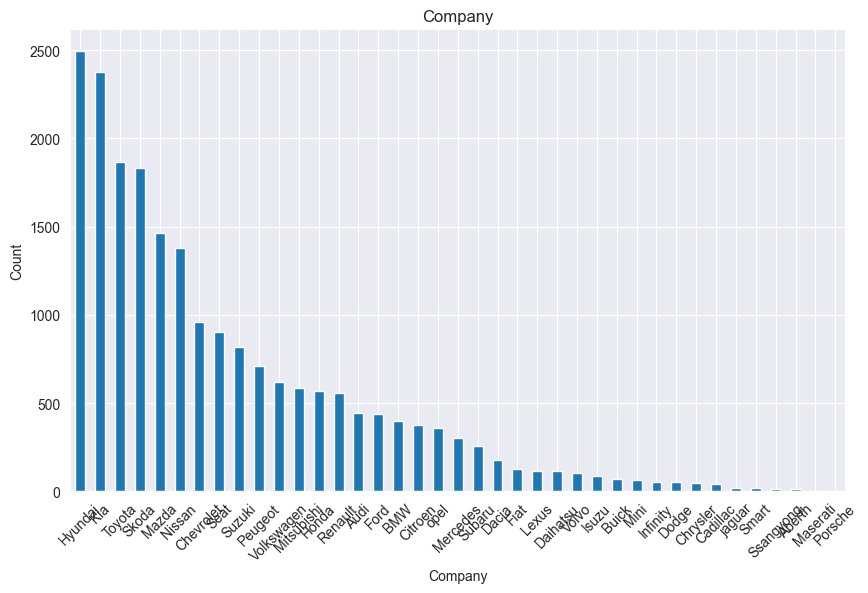

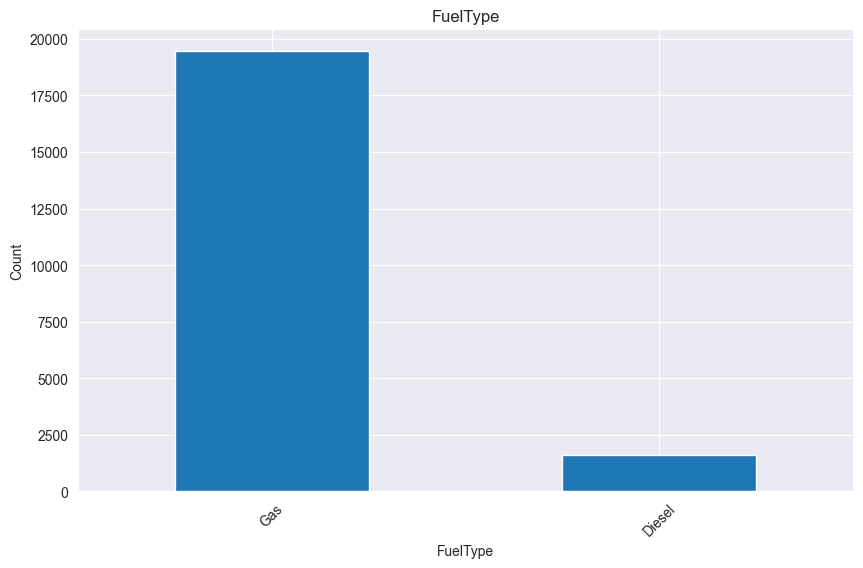

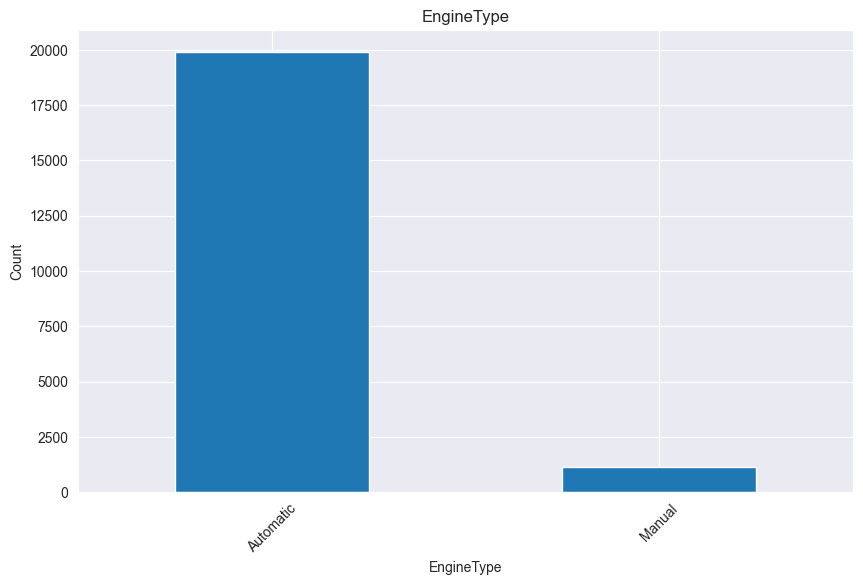

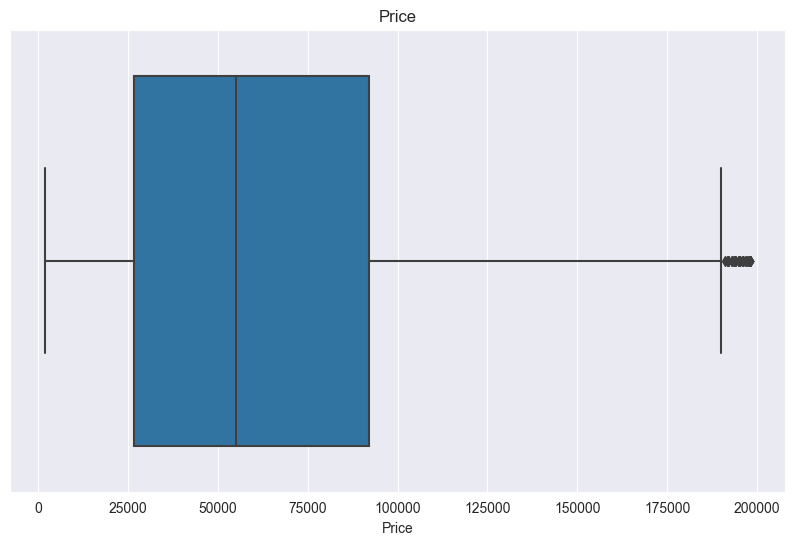

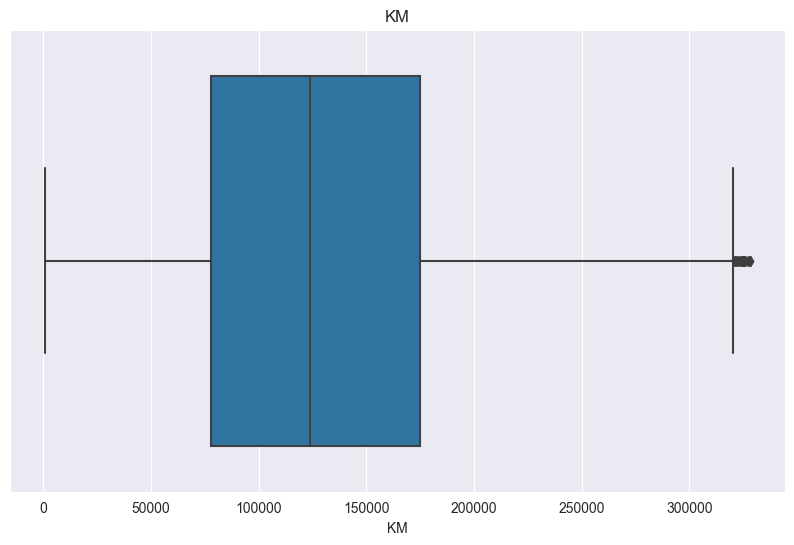

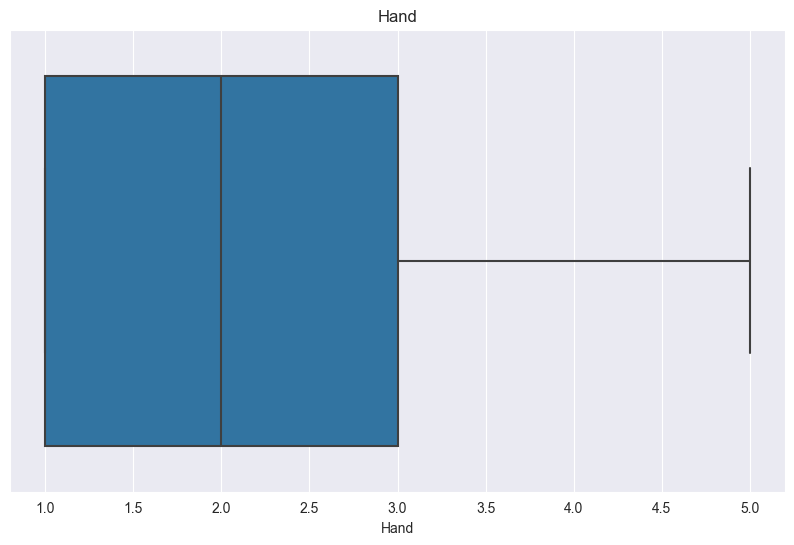

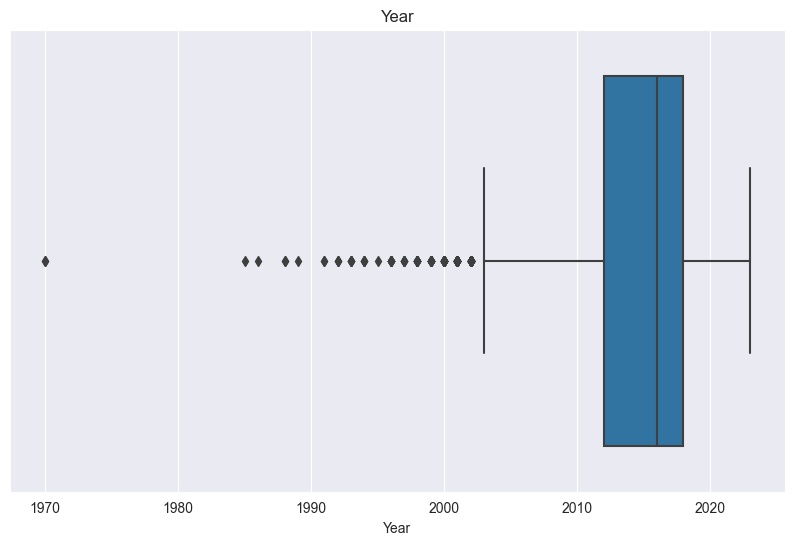

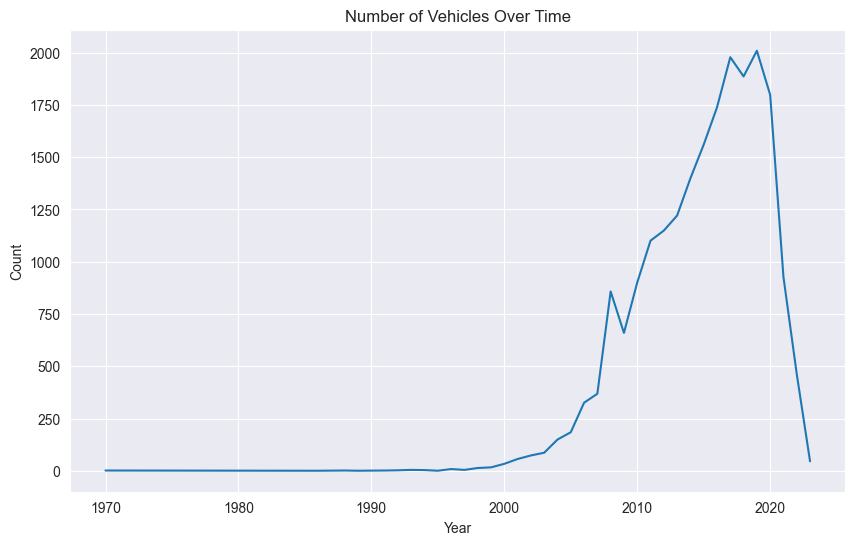

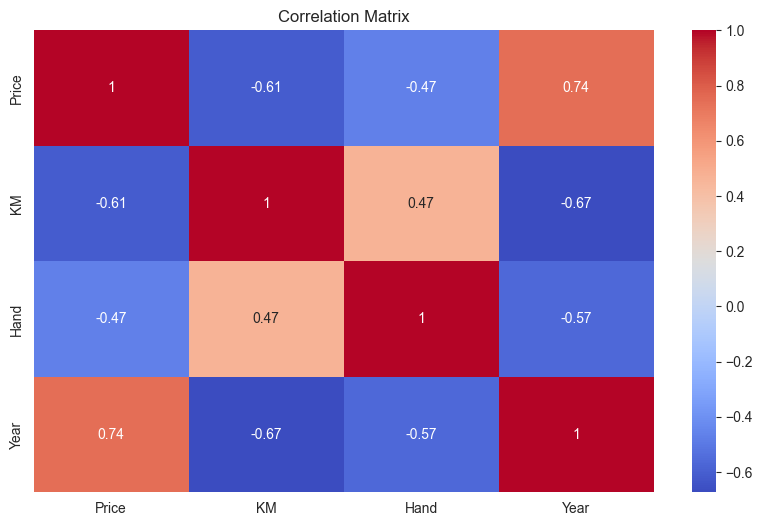

In [63]:
# Histograma between hand and price when hand increase price decrease
numeric_cols = ['Price', 'KM', 'Hand','Year']
categorical_cols = ['Company', 'FuelType', 'EngineType']

df = pd.read_csv('clean_data.csv')

# Bar plots
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Box plots
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col)
    plt.title(col)
    plt.xlabel(col)
    plt.show()

# Time series analysis
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df_yearly = df.groupby(df['Year'].dt.year).size()
plt.figure(figsize=(10, 6))
df_yearly.plot(kind='line')
plt.title('Number of Vehicles Over Time')
plt.xlabel('Year')
plt.ylabel('Count')# Data Cleaning
plt.show()

# Correlation matrix and heatmap
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Machine Learning

This code is an implementation of a machine learning model using linear regression to predict car prices.
*  It begins by reading a dataset from a CSV file and preprocessing the data by encoding categorical features and splitting it into training and testing sets.
* The linear regression model is then instantiated and fitted to the training data. Predictions are made on both the training and testing data, and scatter plots are generated to visualize the predicted prices against the actual prices for both sets.
*  The model's performance is evaluated using R-squared scores, which measure how well the model fits the data. 
* This code provides a practical example of applying linear regression for car price prediction and assessing the model's effectiveness.

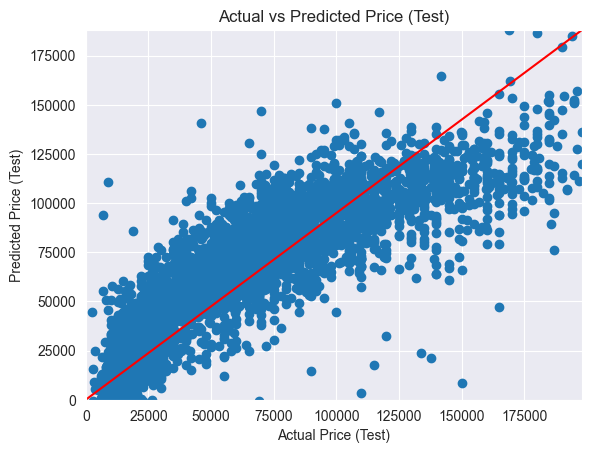

Test Set:
R-squared Score: 0.725617348987977


In [72]:
df = pd.read_csv('clean_data.csv')
X = df[['KM', 'Hand', 'Company', 'Year', 'FuelType', 'EngineType']]
y = df['Price']
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create an instance of the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Plotting actual vs predicted prices for test set
plt.scatter(y_test, y_test_pred)
plt.plot([0, max(y_test)], [0, max(y_test_pred)], color='red')
plt.xlabel("Actual Price (Test)")
plt.ylabel("Predicted Price (Test)")
plt.title("Actual vs Predicted Price (Test)")
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test_pred))
plt.show()


# Evaluate the model
r2_test = r2_score(y_test, y_test_pred)

print("Test Set:")
print("R-squared Score:", r2_test)


# RandomForestRegressor

This code loads the clean dataset from a CSV file and separates the features (KM, Hand, Year, FuelType, EngineType) from the target variable (Price). It performs one-hot encoding on the categorical features and applies feature scaling using StandardScaler. The data is then split into training and test sets.

A Random Forest Regressor model with 100 estimators is created and fitted to the training data. Predictions are made on both the training and test data. Scatter plots are generated to visualize the predicted prices compared to the actual prices for both sets.

The model's performance is evaluated using the R-squared score, a measure of how well the model fits the data. The R-squared scores are printed for both the training and test sets.

This code demonstrates the use of Random Forest Regressor as an alternative machine learning algorithm for predicting car prices and assesses its performance compared to the initial Linear Regression model.

In [79]:
df = pd.read_csv('clean_data.csv')

# Separate features and target variable
X = df[['KM', 'Hand', 'Year', 'FuelType', 'EngineType']]
y = df['Price']

# Perform one-hot encoding for categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Perform feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create an instance of the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)
# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Evaluate the model
r2_test = r2_score(y_test, y_test_pred)

print("Test Set:")
print("R-squared Score:", r2_test)

Test Set:
R-squared Score: 0.5926547665144122
